In [ ]:
# Run this cell if you opened this notebook in Google Colab
!git clone https://github.com/Mouret-Orfeu/RCA_LLM_project.git
%cd RCA_LLM_project

!python -m pip install --upgrade pip
!pip install -r requirements.txt
!pip install -e .

In [ ]:
# Run this cell for local execution
import os
os.chdir('...') # path to the root of the project

In [2]:
model_types_to_review = ["meta-llama/Llama-3.2-1B-Instruct"]
max_iters_list_to_review = [200]
perf_metrics_to_review = ["byte_perplexity", "bits_per_byte", "exact_match", "token_lvl_f1", "rougeL_f1"]
split_to_review = ["split_1", "split_2", "split_3", "split_4", "split_5"]



In [3]:
# This cell normalizes and echoes them for later cells.
selected_models = list(model_types_to_review)
selected_max_iters = list(max_iters_list_to_review)
selected_metrics = list(perf_metrics_to_review)
selected_splits = list(split_to_review)

print('Models to review:', selected_models)
print('Max iters to review:', selected_max_iters)
print('Metrics to review:', selected_metrics)
print('Splits to review:', selected_splits)


Models to review: ['meta-llama/Llama-3.2-1B-Instruct']
Max iters to review: [200]
Metrics to review: ['byte_perplexity', 'bits_per_byte', 'exact_match', 'token_lvl_f1', 'rougeL_f1']
Splits to review: ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']


In [ ]:
# This cell loads the performance DataFrame and displays the relevant metrics for the selected models, max iters, metrics, and splits.
import pandas as pd
from pathlib import Path
import re

perf_path = Path('perf/model_perf_df.pkl')
if not perf_path.exists():
    print(f'Perf file not found at {perf_path}')
else:
    perf_df = pd.read_pickle(perf_path)
    # Reshape the DataFrame for easier filtering and display
    df_long = perf_df.T.reset_index()
    df_long.columns = ['model_type','split','perf_metric','training_duration_max_iter','value']
    # Filter using selections from Cell 3
    sel = df_long[
        (df_long['model_type'].isin(selected_models)) &
        (df_long['training_duration_max_iter'].isin(selected_max_iters)) &
        (df_long['perf_metric'].isin(selected_metrics)) &
        (df_long['split'].isin(selected_splits))
    ]
    if sel.empty:
        print('No rows in perf DataFrame for the selected parameters.')
    else:
        for model_name in selected_models:
            for mi in selected_max_iters:
                df_m = sel[(sel['model_type'] == model_name) & (sel['training_duration_max_iter'] == mi)]
                if df_m.empty:
                    continue
                # Pivot to have metrics as columns and splits as rows
                table = df_m.pivot_table(index='split', columns='perf_metric', values='value')
                # Optional: sort split rows numerically, keeping split_avg last
                def split_key(s):
                    if s == 'split_avg':
                        return (9999, 'split_avg')
                    # Extract numeric part for sorting
                    m = re.search(r'(\d+)', str(s))
                    return (int(m.group(1)) if m else 0, s)
                # Sort the table index using the custom key
                table = table.sort_index(key=lambda idx: [split_key(s) for s in idx])
                print(f'\nPerformance metrics for model={model_name}, max_iter={mi}:')
                try:
                    #display as a table
                    display(table)
                except Exception:
                    print(table)



Performance metrics for model=meta-llama/Llama-3.2-1B-Instruct, max_iter=200:


perf_metric,bits_per_byte,byte_perplexity,exact_match,rougeL_f1,token_lvl_f1
split,,,,,
split_1,0.099123,1.071122,0.000,0.319755,0.381898
split_2,0.059961,1.042437,0.000,0.415371,0.461949
split_3,0.054523,1.038515,0.025,0.344033,0.401066
split_4,0.045585,1.032101,0.025,0.419024,0.478038
split_5,0.041212,1.028978,0.025,0.385483,0.453952


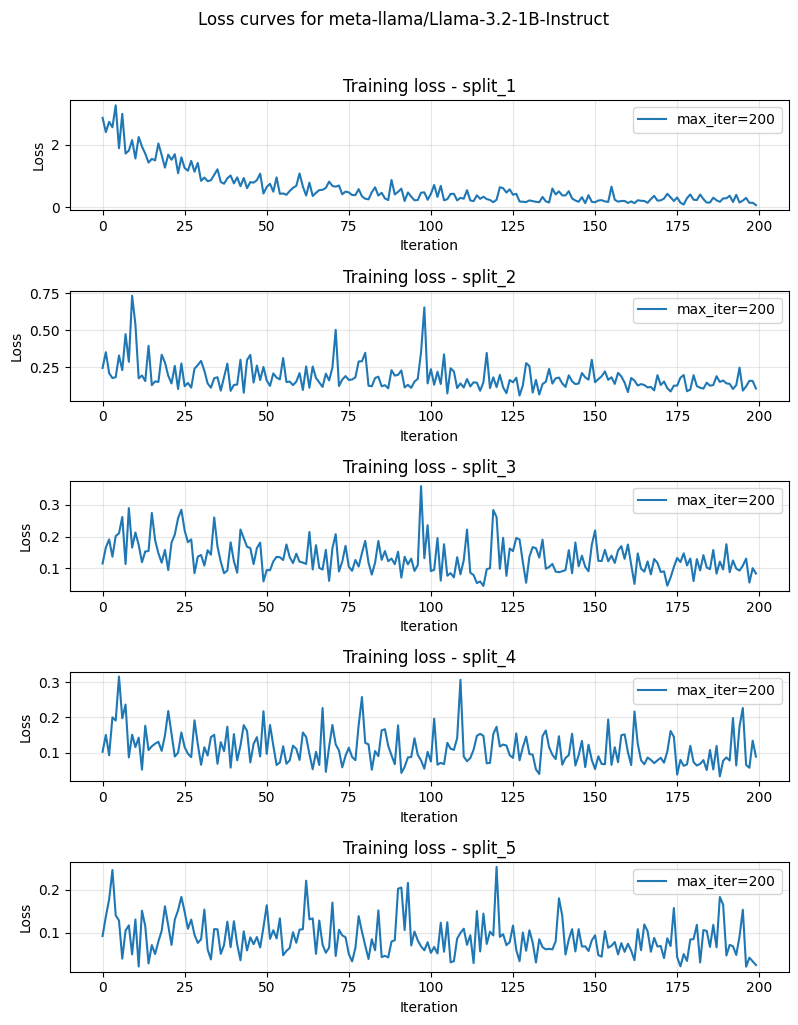

In [ ]:
# This cell plots the training loss curves for the selected models, max iters, and splits.
import pandas as pd
from pathlib import Path

try:
    import matplotlib.pyplot as plt
except Exception as e:
    plt = None
    print('Matplotlib not available; falling back to printing CSV heads.', e)

# Loss curves are only meaningful per concrete split;
# stop if an aggregate split is requested.
if any(s == 'split_avg' for s in selected_splits):
    raise ValueError("'split_avg' is an aggregate and has no loss curve; please select a concrete split like 'split_1'..'split_5'.")

for model_name in selected_models:
    logs_root = Path('perf/model_training_log') / model_name.replace('/', '__')
    if not logs_root.exists():
        print(f'Logs root not found: {logs_root}')
        continue
    # Determine which splits to plot
    concrete_split_dirs = sorted(p for p in logs_root.glob('split_*') if p.is_dir())
    if not selected_splits:
        splits_to_plot = [p.name for p in concrete_split_dirs]
    else:
        wanted = set(selected_splits)
        splits_to_plot = [p.name for p in concrete_split_dirs if p.name in wanted]
        missing = [s for s in selected_splits if s not in set(splits_to_plot)]
        if missing:
            print(f'Warning: missing splits for {model_name}: {missing}')
    # Collect loss data for each split and max_iter
    data_by_split = {}
    for split_name in splits_to_plot:
        split_dir = logs_root / split_name
        data_by_split[split_name] = {}
        for mi in selected_max_iters:
            run_dirs = sorted(split_dir.glob(f'maxiter_{mi}__*'))
            if not run_dirs:
                continue
            run = run_dirs[-1]  # latest by name
            csv_path = run / 'training_loss_per_batch.csv'
            if csv_path.exists():
                try:
                    df_loss = pd.read_csv(csv_path)
                    data_by_split[split_name][mi] = df_loss
                except Exception as e:
                    print(f'Failed reading {csv_path}: {e}')
    if not data_by_split:
        print(f'No training loss CSVs found for the selected parameters for {model_name}.')
        continue
    if plt is not None:
        splits_sorted = sorted(data_by_split.keys(), key=lambda s: int(''.join(filter(str.isdigit, s)) or 0))
        n_rows = len(splits_sorted)
        fig, axes = plt.subplots(n_rows, 1, figsize=(8, max(3, 2*n_rows)), sharex=False)
        if n_rows == 1:
            axes = [axes]
        for ax, split_name in zip(axes, splits_sorted):
            mi_dict = data_by_split[split_name]
            for mi in sorted(mi_dict.keys()):
                df_loss = mi_dict[mi]
                if 'iter' in df_loss.columns and 'loss' in df_loss.columns:
                    ax.plot(df_loss['iter'], df_loss['loss'], label=f'max_iter={mi}')
                else:
                    ax.plot(range(len(df_loss)), df_loss.iloc[:,1], label=f'max_iter={mi}')
            ax.set_title(f'Training loss - {split_name}')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')
            ax.grid(True, alpha=0.3)
            ax.legend()
        fig.suptitle(f'Loss curves for {model_name}', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        for split_name, mi_dict in sorted(data_by_split.items()):
            print(f'\n{model_name} - {split_name}')
            for mi, df_loss in sorted(mi_dict.items()):
                print(f'max_iter={mi}\n', df_loss.head())
